# Simple Stellar Population (SSP) Feedback with SYGMA

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from NuPyCEE import sygma
from NuPyCEE import omega
import fsps
import h5py

yield_dir = 'yield_tables/'

### Set parameters for SYGMA

In [3]:
# Parameter dictionary
params = dict()

# AGB and massive stars yields
params["table"] = yield_dir+'agb_and_massive_stars_K10_LC18_Ravg.txt'
params["imf_yields_range"] = [1.0, 100.0] # [Msun] - Stars in that mass range will eject metals

# Transition mass between AGB and massive star yields
# !!! --> CC SNe will be counted from the transition mass up to imf_yields_range[1]
params["transitionmass"] = 8.0 # [Msun]

# Type of IMF - can be a custom one
params["imf_type"] = 'chabrier'
params["imf_bdys"] = [0.1, 100] # [Msun] - Lower and upper limit of the IMF

# Mass of the stellar population [Msun]
params["mgal"] = 1.0

# SNe Ia
params["sn1a_table"] = yield_dir+'sn1a_i99_W7.txt'
params["nb_1a_per_m"] = 1.0e-3 # Number of SN Ia per units of Msun formed
params["sn1a_rate"] = 'power_law' # Shape (delay-time distribution) of the SN Ia rate
params["beta_pow"] = -1.0 # Slope of the power law (SN Ia rate)

# Neutron star mergers (NSMs)
params["ns_merger_on"] = True
params["nsmerger_table"] = yield_dir+'r_process_arnould_2007.txt' # r-process table (based on the solar composition)
params["nsm_dtd_power"] = [3.0e7, 1.0e10, -1.0] # Shape of the NSM rate, t^-1 from 30 Myr to 10 Gyr
params["nb_nsm_per_m"] = 1.5e-5 # Number of NSM per units of Msun formed
params["m_ej_nsm"] = 1.0e-2 # Mass ejected by each NSM 

# Timestep of the output
params["dt"] = 1.0e6
params["special_timesteps"] = 100 # Logarithmic timesteping
# See more timestep options here: 
# https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb

### Set parameters for FSPS
http://dfm.io/python-fsps/current/stellarpop_api/

In [4]:
# There should only ever be one StellarPopulation instance!
sp = fsps.StellarPopulation(zcontinuous=1, # specify single metallicity
                            sfh=0)         # compute an SSP; i.e., no SF hist
                                           # SF is always normalized to 1

In [5]:
sp.params['zred'] = 0.0

# IMF - can still be custom
sp.params['imf_type'] = 1 # Chabrier
sp.params['imf_lower_limit'] = params['imf_bdys'][0]
sp.params['imf_upper_limit'] = params['imf_bdys'][1]

# Major feature toggles
sp.params['add_neb_emission'] = False  # from Cloudy
sp.params['add_neb_continuum'] = False # off if neb emis is False
sp.params['nebemlineinspec'] = False   # incl emission fluxes in spectra

sp.params['add_agb_dust_model'] = True  # scaled by agb_dust
sp.params['add_dust_emission'] = False  # Draine & Li 2007; for CSPs
sp.params['cloudy_dust'] = False        # incl dust in Cloudy tables

sp.params['add_stellar_remnants'] = True # incl remnants in stellar mass calc

# Add stellar velocity dispersion or wavelength smoothing; default is none
sp.params['smooth_velocity'] = True # False smooths in wavelength space
sp.params['sigma_smooth'] = 0.0     # if smooth_velocity, dispersion in km/s

print('Isochrone & Spectral libraries:', sp.libraries,
      '(can only be changed by recompiling FSPS)')

Isochrone & Spectral libraries: (b'mist', b'miles', b'DL07') (can only be changed by recompiling FSPS)


### Extract the list of available metallicities

In [6]:
# Run a dummy chemical evolution calculation to access the table info
o_dummy = omega.omega(table=params["table"])
Z_table = o_dummy.Z_table
nb_Z = len(Z_table)

# Print the metallicities
print("\nAvailable metallicities (Z, mass fraction)")
print("  ",Z_table)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.3s

Available metallicities (Z, mass fraction)
   [0.02, 0.01345, 0.008, 0.004, 0.003236, 0.0003236, 0.0001, 3.236e-05]


### Run SYGMA for all available metallicities

In [7]:
sygma_instances = []
for Z in Z_table:
    sygma_instances.append(sygma.sygma(iniZ=Z, **params))

SYGMA run in progress..
   SYGMA run completed - Run time: 0.08s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.08s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.08s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.08s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s


### Run FSPS for all available metallicities

In [8]:
fsps_outputs = []
Z_sol = 0.01295 # consistent with the grackle CLOUDY tables
for Z in Z_table:
    sp.params['logzsol'] = np.log10(Z/Z_sol)
    
wave, spec = sp.get_spectrum(peraa=True)

In [9]:
wave.shape, spec.shape, sp.log_age.shape

((5994,), (107, 5994), (107,))

Text(0, 0.5, 'log(sum(spectra))')

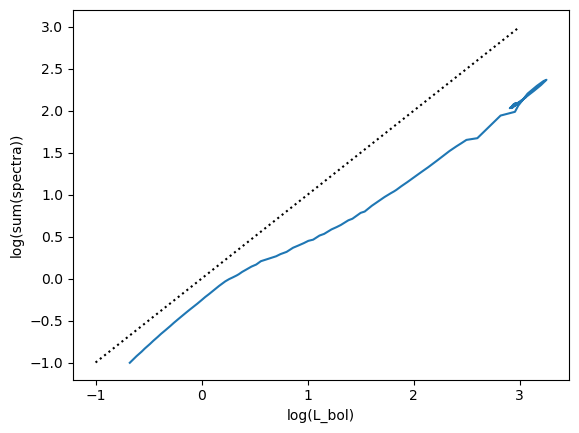

In [10]:
plt.plot(sp.log_lbol, np.log10(spec.sum(axis=1)))
plt.plot(np.linspace(-1,3), np.linspace(-1,3), 'k:')
plt.xlabel('log(L_bol)')
plt.ylabel('log(sum(spectra))')

### Create feedback table

In [11]:
source_indx = {"type2": 0,
               "type1a": 1,
               "agb": 2,
               "massive": 3}

nb_src = len(source_indx)

# Get the ages tracked by each SYGMA instance (i.e. each metallicity)
# Ensure they are all the same and are special_timesteps+1 in number
ages = np.array([inst.history.age for inst in sygma_instances])
assert np.isclose(ages, ages[0]).all()
assert np.all(ages.shape[1] == params["special_timesteps"]+1)
nb_dt = params["special_timesteps"]

met_key = np.zeros(nb_Z)
age_key = ages[0]

mass_table = np.zeros((nb_Z, nb_dt, nb_src))
metl_table = np.zeros_like(mass_table)
evnt_table = np.zeros((nb_Z, nb_dt, 2)) # just supernovae

for i_Z in range(nb_Z):

    model = sygma_instances[i_Z]
    met_key[i_Z] = model.iniZ
    hist = model.history

    # SYGMA histories use a mix of lists & numpy arrays
    ism_elem_yield_sn2 = [hist.ism_elem_yield[i] - 
                          (hist.ism_elem_yield_agb[i] +
                           hist.ism_elem_yield_1a[i]  +
                           hist.ism_elem_yield_massive[i])
                          for i in range(len(hist.ism_elem_yield))]
    
    ism_elem_yield_sn2[0][0] = 0 # this is erroneously set to 1 for some reason

    # Each set of ISM yields is time-integrated
    # Use NumPy to differentiate in order to keep data the same shape
    # (i.e., # ages by # elements, which is 81)
    # inst_yield_sn2     = np.gradient(ism_elem_yield_sn2, hist.age, axis=0)
    # inst_yield_sn1a    = np.gradient(hist.ism_elem_yield_1a, hist.age, axis=0)
    # inst_yield_agb     = np.gradient(hist.ism_elem_yield_agb, hist.age, axis=0)
    # inst_yield_massive = np.gradient(hist.ism_elem_yield_massive, hist.age, axis=0)

    # Each set of ISM yields is time-integrated
    # Manually differentiate so that we have nb_dt entries
    # (the first axis dimension matches the number of ages, which is nb_dt+1)
    # Division by the timestep (in yr) will happen after summing
    inst_yield_sn2     = np.diff(ism_elem_yield_sn2, axis=0)
    inst_yield_sn1a    = np.diff(hist.ism_elem_yield_1a, axis=0)
    inst_yield_agb     = np.diff(hist.ism_elem_yield_agb, axis=0)
    inst_yield_massive = np.diff(hist.ism_elem_yield_massive, axis=0)

    # The gradient goes negative at some parts near the highest ages so set these to 0
    inst_yield_sn2     = np.where(inst_yield_sn2 < 0, 0, inst_yield_sn2)
    inst_yield_sn1a    = np.where(inst_yield_sn1a < 0, 0, inst_yield_sn1a)
    inst_yield_agb     = np.where(inst_yield_agb < 0, 0, inst_yield_agb)
    inst_yield_massive = np.where(inst_yield_massive < 0, 0, inst_yield_massive)

    # Collect mass injected by each source (i.e. sum over all elements)
    mass_table[i_Z, :, source_indx["type2"]]   = inst_yield_sn2.sum(axis=1) / hist.timesteps 
    mass_table[i_Z, :, source_indx["type1a"]]  = inst_yield_sn1a.sum(axis=1) / hist.timesteps
    mass_table[i_Z, :, source_indx["agb"]]     = inst_yield_agb.sum(axis=1) / hist.timesteps
    mass_table[i_Z, :, source_indx["massive"]] = inst_yield_massive.sum(axis=1) / hist.timesteps

    # Collect metal mass injected by each source
    # (i.e. sum over all metal elements)
    metl_table[i_Z, :, source_indx["type2"]]   = inst_yield_sn2[:, 2:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["type1a"]]  = inst_yield_sn1a[:, 2:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["agb"]]     = inst_yield_agb[:, 2:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["massive"]] = inst_yield_massive[:, 2:].sum(axis=1) / hist.timesteps

    # Number of SNe per year
    evnt_table[i_Z, :, source_indx["type2"]]  = model.sn2_numbers / hist.timesteps
    evnt_table[i_Z, :, source_indx["type1a"]] = model.sn1a_numbers / hist.timesteps

# Convert metal mass to metal fraction
metl_table /= mass_table 

# Set all nan to zero (because there was no total mass in those cells)
np.nan_to_num(metl_table, copy=False) # in-place

# Perform final checks & unit conversions
assert (mass_table >= 0).all()
assert (metl_table >= 0).all()
assert (evnt_table >= 0).all()

# Convert rates to per second?

/tmp/ipykernel_8985/203741976.py:78: RuntimeWarning: invalid value encountered in divide
  metl_table /= mass_table


### Write tables to HDF5

In [16]:
with h5py.File("output_tables/sygma_feedback_table.h5", "w") as f:

    # Group for indexers
    index_grp = f.create_group("indexers")

    # Write source key as attributes
    for key, item in source_indx.items():
        index_grp.attrs[key+"_index"] = item

    index_grp.create_dataset("initial_metallicity", data=met_key)
    index_grp.create_dataset("population_age", data=age_key)

    # Group for SYGMA models
    sygma_grp = f.create_group("sygma_models")

    # Write SYGMA parameters as attributes
    for key, item in params.items():
        sygma_grp.attrs[key] = item

    mass_dset = sygma_grp.create_dataset("ejecta_mass", data=mass_table)
    metl_dset = sygma_grp.create_dataset("ejecta_metal_frac", data=metl_table)
    evnt_dset = sygma_grp.create_dataset("sne_event_rate", data=evnt_table)

    # also create group for fsps models 
    # and write model params to attr of that group
    